In [ ]:
import numpy as np
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import pickle

In [25]:
# Distinct Pateints = 108, 7 patients have come repeatedly
# 67 NORMAL cases, hence, num XMLs = 410 - 67 = 343

In [26]:
# Make dictionary of the form: {patient_id: {L: [MLO, CC], R: [MLO, CC]}, ..}
diction = {}
for file in os.listdir("/home/anvit/Desktop/Data/INbreast/Original_Inbreast/AllDICOMs/"):
    arr = file.split("_")
    if(arr[1] not in diction):
        diction[arr[1]] = {}
        diction[arr[1]][arr[3]] = [arr[0]]

    else:
        if(arr[3] not in diction[arr[1]]):
            diction[arr[1]][arr[3]] = [arr[0]]
        else:
            diction[arr[1]][arr[3]].append(arr[0])
print(len(diction))

modified_diction = {}
for elem in diction:
    try:
        if(len(diction[elem]['L'])==2):
            modified_diction[diction[elem]['L'][0]] = diction[elem]['L'][1]
    except:
        continue
        
for elem in diction:        
    try:
        if(len(diction[elem]['R'])==2):
            modified_diction[diction[elem]['R'][0]] = diction[elem]['R'][1]
    except:
        continue

108


In [27]:
modified_diction

{'20586934': '20586986',
 '20586960': '20586908',
 '20587080': '20587054',
 '20587148': '20587200',
 '20587226': '20587174',
 '20587346': '20587294',
 '20587372': '20587320',
 '20587466': '20587518',
 '20587544': '20587492',
 '20587638': '20587690',
 '20587664': '20587612',
 '20587784': '20587836',
 '20587810': '20587758',
 '20587902': '20587928',
 '20587994': '20588046',
 '20588020': '20588072',
 '20588138': '20588164',
 '20588190': '20588216',
 '20588308': '20588334',
 '20588458': '20588510',
 '20588536': '20588562',
 '22427682': '22427728',
 '22427751': '22427705',
 '22427864': '22579754',
 '22579730': '22427840',
 '22579847': '22579893',
 '22579916': '22579870',
 '22580015': '22580068',
 '22580038': '22580098',
 '22580192': '22580244',
 '22580218': '22580270',
 '22580341': '22580393',
 '22580367': '22580419',
 '22580520': '22580576',
 '22580548': '22580492',
 '22580654': '22580706',
 '22580732': '22580680',
 '22613650': '22613702',
 '22613676': '22613624',
 '22613770': '22613822',


In [28]:
# Count number of NORMAL cases
count = 0
file = open("/home/anvit/Desktop/Data/INbreast/Original_Inbreast/INbreast.csv")
lines = file.readlines()
for line in lines:
    arr = line.split(",")
    if(arr[7] == '1\n'):
        count += 1 
print(count)
print(410-count) # Num with lesions

67
343


In [29]:
# Obtain array of BENIGN cases
benign = []
malignant = []
normal = []
file = open("/home/anvit/Desktop/Data/INbreast/Original_Inbreast/INbreast.csv")
lines = file.readlines()
lines = lines[1:]
for line in lines:
    arr = line.split(",")
    if(arr[7] == '2\n' or arr[7] == '3\n'):
        benign.append(arr[5])
    elif(arr[7] != '1\n'):
        malignant.append(arr[5])
    elif(arr[7] == '1\n'):
        normal.append(arr[5])
        
print(len(benign))
print(343-len(benign)) # Num malignant
print(len(malignant))
print(len(normal))

243
100
100
67


/home/anvit/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/anvit/Desktop/Data/INbreast/Original_Inbreast/INbreast.csv' mode='r' encoding='UTF-8'>
  """


In [30]:
# Of the 100 malignant, 10 removed for relabelling, 1 corrupted
# These 89 are resized, non birads objects (benign objects) are removed
# Also 4a is removed since its very similar to 3 and 3 is considered benign
# With 4a removed, only 74 images are left, thereform num 4a = 15

In [31]:
# GT
mal_dict = {}

#for xml in malignant:
for xml in os.listdir("/home/anvit/Desktop/Data/INbreast/XML_VOC_malignant_BIRADS_resized/"):
    tree = ET.parse("/home/anvit/Desktop/Data/INbreast/XML_VOC_malignant_BIRADS_resized/"+xml)
    root = tree.getroot()
    if(len(root.findall('object'))>0): #4a removed
        mal_dict[xml[:-4]] = []
    for obj in root.findall('object'):
        bbox = obj[4]
        xmin = bbox[0].text
        ymin = bbox[1].text
        xmax = bbox[2].text
        ymax = bbox[3].text
        
        temparr = [xmin, ymin, xmax, ymax, 0]
        mal_dict[xml[:-4]].append(temparr)

In [32]:
# GT Authors
mal_dict_authors = {}

fil = open("/home/anvit/Desktop/Data/INbreast/Scripts/resizedgtauthors.txt", 'r')
lines = fil.readlines()

for line in lines:
    arr = line.split(",")
    if(arr[0] not in mal_dict_authors):
        mal_dict_authors[arr[0]] = [[float(arr[1]), float(arr[3]), float(arr[2]), float(arr[4])]]
    else:
        mal_dict_authors[arr[0]].append([float(arr[1]), float(arr[3]), float(arr[2]), float(arr[4])])

print(len(mal_dict_authors))
print(len(malignant))

84
100


/home/anvit/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/anvit/Desktop/Data/INbreast/Scripts/resizedgtauthors.txt' mode='r' encoding='UTF-8'>
  after removing the cwd from sys.path.


In [33]:
# Find files in malignant and not in mal_dict ie - 10 + 1 + 15 = 26
remmal = []
for f in malignant:
    if f not in mal_dict:
        remmal.append(f)
#print(remmal)
#print(len(remmal))

# Find those 8 files (16) image ambiguous ones:
ambi = []
for g in malignant:
    if g not in mal_dict_authors:
        ambi.append(g)
print(len(ambi))

# Find intersection of mal_dict_authors and malignant = mal_dict_authors
for h in mal_dict_authors:
    if h not in malignant:
        print("CRY")

# Identify those 16 ambiguous files
for file in ambi:
    print(file)
    
#Modified malignant: length 84 (not 100)
malignant = []
for j in mal_dict_authors:
    malignant.append(j)
print(len(malignant))

16
50997461
50997515
24055464
24055502
50998059
50998113
26933801
26933859
22614522
22614568
22613918
22613970
22670978
22671003
50996352
50996406
84


/home/anvit/.local/lib/python3.5/site-packages/ipykernel_launcher.py:22: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/anvit/Desktop/Data/INbreast/Original_Inbreast/INbreast.csv' mode='r' encoding='UTF-8'>


In [34]:
# Find files from remmal in mal_dict_authors: - 26 such cases, they have included 4a also in malignant
# They have excluded 8 ambiguous cases - ie 8x2 = 16 images, therefore have 100 - 16 = 84
w = 1
for v in remmal:
    if v in mal_dict_authors:
        w += 1
print(w)

19


In [35]:
# Assuming predictions for each malignant image in the form x_min, x_max, y_min, y_max for all lesions in a different row
# Image_name x_min, y_min, x_max, y_max malignant_confidence
# Assuming predictions sorted image wise

def getdicts(filename):
    #yolov3pred = open("./YOLO_output_files/"+filename,'r')
    yolov3pred = open("./FasterRCNN_output_files/"+filename,'r')
    #yolov3pred = open("/home/anvit/Desktop/RetinaNet/pytorch-retinanet/output_files/"+filename, 'r')

    predictions = yolov3pred.readlines()
    #print(len(predictions))

    pred_dict = {}
    conf_dict = {}
    for row in predictions:
        det = row.split(",")
        if(det[0][:-4] not in pred_dict):
            pred_dict[det[0][:-4]] = [[det[1], det[2], det[3], det[4]]]
            conf_dict[det[0][:-4]] = det[5][:-1]

        else:
            pred_dict[det[0][:-4]].append([det[1], det[2], det[3], det[4]])
            conf_dict[det[0][:-4]] = max(det[5][:-1], conf_dict[det[0][:-4]])
    
    yolov3pred.close()
    
    # Confidence = average confidence of all views
    for l in conf_dict:
        try:
            otherview = modified_diction[l]
            avg = (conf_dict[l] + conf_dict[otherview])/2
            conf_dict[l] = avg
            conf_dict[otherview] = avg
        except:
            continue
    
    return pred_dict, conf_dict

In [36]:
#pred_dict, conf_dict = getdicts("output_yolo_394.txt")
#pred_dict, conf_dict = getdicts("output_yolo_withfreezeandnormal.txt")
#pred_dict, conf_dict = getdicts("output_retinanet_INbreast.txt")
pred_dict, conf_dict = getdicts("det_mal.txt")

In [37]:
#print(pred_dict)
#print(conf_dict)
print(len(pred_dict))

349


In [38]:
# Find malignant images with no predictions - 18 such cases for 343, 18 such cases for 410
keep = 0
for i in mal_dict_authors:
    if i not in pred_dict:
        #print(i)
        keep += 1
print(keep)

# There are 8 images in mal_dict not in mal_dict_authors (must be the 8 ambiguous ones)
# Length mal_dict = 74
# Length mal_dict_authors = 84
# Length malignant = 100

n=1
for i in mal_dict_authors:
    if i not in mal_dict:
        n+=1
#print(n)

0


In [39]:
# METHOD 1
# gtlabel = []
# predconf = []
# for key in conf_dict:
#     gtlabel.append(1)
#     predconf.append(float(conf_dict[key]))

# METHOD 2 - Check only predicted (0.81)
# gtlabel = []
# predconf = []
# for key in conf_dict:
#     if(key in malignant):
#         gtlabel.append(1)
#     else:
#         gtlabel.append(0)
#     predconf.append(float(conf_dict[key]))

In [40]:
# METHOD 3 - Check all (0.73), low thresh of 0.001 - 0.82
# CLASSIFICATION GT LABEL:
imgdir = os.listdir("/home/anvit/Desktop/Data/INbreast/equalized_PNG_394_resized_ambiremoved/")
imgdir.sort()
gtlabel = []

for file in imgdir:
    if(file[:-4] in malignant):
        gtlabel.append(1)
    elif(file[:-4] in benign):
        gtlabel.append(0.0)
    elif(file[:-4] in normal):
        gtlabel.append(0)
        

predconf = []
normalasnormal = 0
for im in imgdir:
    try:
        if(float(conf_dict[im[:-4]]) < 0.001):
            predconf.append(0)
        else:
            predconf.append(float(conf_dict[im[:-4]]))

#         if(im[:-4] in normal):
#             print(float(conf_dict[im[:-4]]))

    except:
#         if(im[:-4] in normal):
#             normalasnormal += 1
        predconf.append(0)

#print(gtlabel)
#print(predconf)
# print(normalasnormal)

In [41]:
#print(gtlabel)
#print(predconf)

# for k in range(len(gtlabel)):
#     if gtlabel[k] == 0:
#         print(predconf[k])

In [42]:
roc_auc_score(gtlabel, predconf)

0.9259024577572964

In [43]:
print(predconf)

[0.304, 0.869, 0.383, 0.884, 0.567, 0.511, 0.161, 0.052, 0.521, 0.086, 0, 0, 0, 0, 0.645, 0.784, 0.555, 0.817, 0.917, 0.155, 0.942, 0.091, 0.341, 0.277, 0.083, 0.204, 0, 0.077, 0.914, 0.277, 0.878, 0.675, 0.267, 0, 0.818, 0.845, 0.298, 0.568, 0.109, 0.674, 0.656, 0.852, 0.059, 0.186, 0.159, 0.734, 0.193, 0.828, 0.956, 0.41, 0.962, 0.656, 0.299, 0.57, 0.119, 0.545, 0.136, 0.91, 0.755, 0.773, 0.11, 0, 0.539, 0, 0.639, 0.761, 0.518, 0.717, 0.111, 0.639, 0.092, 0.235, 0.665, 0, 0.892, 0.326, 0.227, 0.924, 0.058, 0.954, 0.944, 0, 0.944, 0.287, 0.143, 0.051, 0.849, 0.09, 0.752, 0.293, 0.927, 0.89, 0.065, 0.881, 0.147, 0.71, 0.311, 0.357, 0.93, 0.58, 0.867, 0.075, 0.909, 0, 0.749, 0.086, 0.877, 0.94, 0.69, 0.863, 0.613, 0.101, 0.259, 0.055, 0.718, 0, 0.347, 0, 0, 0.179, 0.685, 0.224, 0, 0.223, 0.267, 0.325, 0.491, 0.444, 0.67, 0.628, 0.537, 0.227, 0.241, 0.285, 0, 0.149, 0.091, 0.145, 0.894, 0.676, 0.86, 0.961, 0.113, 0.961, 0.077, 0.793, 0.766, 0.32, 0.766, 0.365, 0.869, 0.758, 0.664, 0.722,

In [44]:
pickle.dump(predconf, open("frcnnconf.pk", "wb"))

/home/anvit/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: ResourceWarning: unclosed file <_io.BufferedWriter name='frcnnconf.pk'>
  """Entry point for launching an IPython kernel.


THRESHOLD: 0.0
84 0 310 0
ACCURACY = 0.2131979695431472
SENSITIVITY = 1.0
SPECIFICITY = 0.0
THRESHOLD: 0.05
68 224 86 16
ACCURACY = 0.7411167512690355
SENSITIVITY = 0.8095238095238095
SPECIFICITY = 0.7225806451612903
THRESHOLD: 0.1
54 275 35 30
ACCURACY = 0.8350253807106599
SENSITIVITY = 0.6428571428571429
SPECIFICITY = 0.8870967741935484
THRESHOLD: 0.15
41 290 20 43
ACCURACY = 0.8401015228426396
SENSITIVITY = 0.4880952380952381
SPECIFICITY = 0.9354838709677419
THRESHOLD: 0.2
33 299 11 51
ACCURACY = 0.8426395939086294
SENSITIVITY = 0.39285714285714285
SPECIFICITY = 0.964516129032258
THRESHOLD: 0.25
21 306 4 63
ACCURACY = 0.8299492385786802
SENSITIVITY = 0.25
SPECIFICITY = 0.9870967741935484
THRESHOLD: 0.3
14 306 4 70
ACCURACY = 0.8121827411167513
SENSITIVITY = 0.16666666666666666
SPECIFICITY = 0.9870967741935484
THRESHOLD: 0.35
8 306 4 76
ACCURACY = 0.7969543147208121
SENSITIVITY = 0.09523809523809523
SPECIFICITY = 0.9870967741935484
THRESHOLD: 0.4
3 307 3 81
ACCURACY = 0.7868020304568

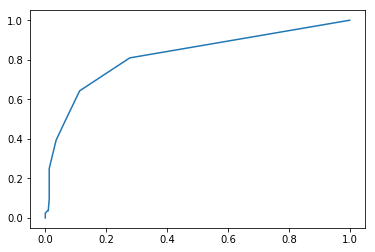

In [75]:
# CLASSIFICATION - IMAGE LEVEL
sens = []
spec = []
accu = []
ones = []
for thresh in [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]:
    print("THRESHOLD:",thresh)
    tp = 0
    fp = 0
    fn = 0
    tn = 0
#    for key in conf_dict: # BUT WHAT ABOUT THOSE THAT ARE NOT PREDICTED
#         if float(conf_dict[key]) >= thresh and (key in mal_dict):
#             tp += 1
#         elif float(conf_dict[key]) >= thresh and (key not in mal_dict):
#             fp += 1
#         elif float(conf_dict[key]) < thresh and (key in mal_dict):
#             fn += 1
#         elif float(conf_dict[key]) < thresh and (key not in mal_dict):
#             tn += 1

    for key in os.listdir("/home/anvit/Desktop/Data/INbreast/equalized_PNG_394_resized_ambiremoved/"):
        key = key[:-4]
        try:
            if float(conf_dict[key]) >= thresh and (key in mal_dict_authors):
                tp += 1
            elif float(conf_dict[key]) >= thresh and (key not in mal_dict_authors):
                fp += 1
            elif float(conf_dict[key]) < thresh and (key in mal_dict_authors):
                fn += 1
            elif float(conf_dict[key]) < thresh and (key not in mal_dict_authors):
                tn += 1
        except:
            # Not predicted
            fn += 1 # Penalty for missing
            continue
    
    #print("ACCURACY = ", tp/len(malignant))
    print(tp,tn,fp,fn)
    acc = (tp + tn)/len(conf_dict)
    sen = tp/(tp + fn)
    spe = tn/(tn + fp)
    print("ACCURACY =", acc)
    print("SENSITIVITY =", sen)
    print("SPECIFICITY =", spe)
    accu.append(acc)
    sens.append(sen)
    spec.append(spe)
    ones.append(1)

tpr = np.array(sens)
fpr = np.array(ones) - np.array(spec)
print("ROC CURVE")
plt.plot(fpr, tpr)

In [79]:
# GENERATE MULTIPLE THRESHOLD FILES:

def generatefile(thresh):
    read = open("./YOLO_output_files/output_yolo_withfreezeandnormal.txt", 'r')
    #read = open("./FasterRCNN_output_files/det_mal.txt", 'r')
    #read = open("/home/anvit/Desktop/RetinaNet/pytorch-retinanet/output_files/output_retinanet_INbreast.txt", 'r')
    outputname = "./YOLO_output_files/output_yolo_" + str(thresh) + ".txt"
    #outputname = "./FasterRCNN_output_files/output_frcnn_" + str(thresh) + ".txt"
    #outputname = "/home/anvit/Desktop/RetinaNet/pytorch-retinanet/output_files/output_retinanet_" + str(thresh) + ".txt"
    write = open(outputname, 'w')
    
    lines = read.readlines()
    for line in lines:
        arr = line.split(",")
        if( float(arr[5]) >= thresh):
        #if(float(arr[5]) >= thresh):
            write.write(line)
    read.close()
    write.close()

In [80]:
generatefile(0.001)
generatefile(0.003)
generatefile(0.005)
#generatefile(0.007)
generatefile(0.01)
generatefile(0.02)
generatefile(0.03)
generatefile(0.04)
generatefile(0.05)
generatefile(0.06)
generatefile(0.07)
generatefile(0.08)
generatefile(0.09)
generatefile(0.1)
generatefile(0.15)
generatefile(0.2)
generatefile(0.25)
generatefile(0.3)
generatefile(0.35)
generatefile(0.4)
generatefile(0.45)
generatefile(0.5)
generatefile(0.55)
generatefile(0.6)
generatefile(0.65)
generatefile(0.7)
generatefile(0.75)
generatefile(0.8)
generatefile(0.85)
generatefile(0.9)
generatefile(0.95)

In [87]:
# NUM OF FALSE POSTIVE BOXES generated for each test image
# TO ADD - Benign score, with inc threshold, even number of benign pred should reduce
pd = []
tpforsens = []
fnforsens = []
t = [0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
for thresh in t:
    print("THRESHOLD,", thresh)
    pred_dict, conf_dict = getdicts("output_yolo_" + str(thresh) + ".txt")
    #pred_dict, conf_dict = getdicts("output_frcnn_" + str(thresh) + ".txt")
    #pred_dict, conf_dict = getdicts("output_retinanet_" + str(thresh) + ".txt")

    
    fpcount = 0
    tpcount = 0
    # pi = predicted image
    for pi in pred_dict:
        preds = pred_dict[pi]
        conf = conf_dict[pi]
        try:
            gt = mal_dict_authors[pi]
        except:
            fpcount += len(preds)
            continue
        
        orig = len(preds)
        possiblefp = len(preds)
        
        for pred_lesion in preds:
            xmid = (float(pred_lesion[0]) + float(pred_lesion[2]))/2
            ymid = (float(pred_lesion[1]) + float(pred_lesion[3]))/2
            for gt_lesion in gt:
                if ( (xmid >= float(gt_lesion[0]) and xmid <= float(gt_lesion[2])) and (ymid >= float(gt_lesion[1]) and ymid <= float(gt_lesion[3])) ): #and float(conf) >= thresh): # and gt_lesion[4] == 0):
                    tpcount += 1
                    possiblefp -= 1
                    #gt_lesion[4] = 1
        fpcount += max(possiblefp,0)
        #print("Number of FPs for image", str(pi), " = ", max(0,possiblefp), "out of", str(orig))
    
    #print("Avg number of FP per image =", fpcount/len(mal_dict_authors))
    print("Avg number of FP per image =", fpcount/394)
    print("Number of TP =", tpcount)
    pd.append(fpcount/394)
    tpforsens.append(tpcount)
    
    fncount = 0
    
    for gti in  mal_dict_authors:
        gt = mal_dict_authors[gti]
        orig = len(gt)
        possiblefn = len(gt)
        try:
            preds = pred_dict[gti]
            for gt_lesion in gt:
                for pred_lesion in preds:
                    xmid = (float(pred_lesion[0]) + float(pred_lesion[2]))/2
                    ymid = (float(pred_lesion[1]) + float(pred_lesion[3]))/2
                    #print(xmid, ymid)
                    if(xmid >= float(gt_lesion[0]) and xmid <= float(gt_lesion[2])) and (ymid >= float(gt_lesion[1]) and ymid <= float(gt_lesion[3])):
                        possiblefn -= 1
                        gt_lesion[4] = 1
                        break

            fncount += possiblefn
            #print("Number of FNs for image", str(gti), "=", possiblefn, "out of", str(orig))
        except:
            fncount += possiblefn
            #print("Number of FNs for image", str(gti), "=", possiblefn, "out of", str(orig))
    
    print("Number of FN =", fncount)
    fnforsens.append(fncount)
    print("Sensitivity =", tpcount/(tpcount + fncount))

THRESHOLD, 0.02
Avg number of FP per image = 3.8781725888324874
Number of TP = 813
Number of FN = 18
Sensitivity = 0.9783393501805054
THRESHOLD, 0.03
Avg number of FP per image = 2.027918781725888
Number of TP = 648
Number of FN = 20
Sensitivity = 0.9700598802395209
THRESHOLD, 0.04
Avg number of FP per image = 1.2563451776649746
Number of TP = 527
Number of FN = 23
Sensitivity = 0.9581818181818181
THRESHOLD, 0.05
Avg number of FP per image = 0.8604060913705583
Number of TP = 424
Number of FN = 26
Sensitivity = 0.9422222222222222
THRESHOLD, 0.06
Avg number of FP per image = 0.631979695431472
Number of TP = 361
Number of FN = 28
Sensitivity = 0.9280205655526992
THRESHOLD, 0.07
Avg number of FP per image = 0.4720812182741117
Number of TP = 301
Number of FN = 33
Sensitivity = 0.9011976047904192
THRESHOLD, 0.08
Avg number of FP per image = 0.3604060913705584
Number of TP = 263
Number of FN = 34
Sensitivity = 0.8855218855218855
THRESHOLD, 0.09
Avg number of FP per image = 0.2893401015228426


Text(0, 0.5, 'Sensitivity')

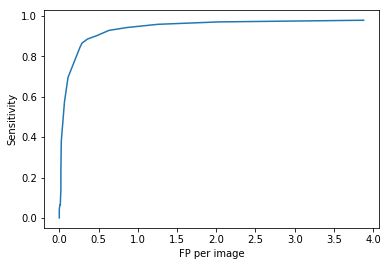

In [88]:
#FROC Curve
pd = np.array(pd)
tpforsens = np.array(tpforsens)
fnforsens = np.array(fnforsens)
sens_froc = tpforsens/(tpforsens + fnforsens)

plt.plot(pd, sens_froc)
plt.xlabel("FP per image")
plt.ylabel("Sensitivity")

In [ ]:
# # NUM OF FALSE NEGATIVE BOXES - for each gt box, num of boxes per image not generated

# # gti = ground truth image
# for gti in  mal_dict:
#     gt = mal_dict[gti]
#     orig = len(gt)
#     possiblefn = len(gt)
#     try:
#         preds = pred_dict[gti]
#         for gt_lesion in gt:
#             for pred_lesion in preds:
#                 xmid = (float(pred_lesion[0]) + float(pred_lesion[2]))/2
#                 ymid = (float(pred_lesion[1]) + float(pred_lesion[3]))/2
#                 #print(xmid, ymid)
#                 if(xmid >= float(gt_lesion[0]) and xmid <= float(gt_lesion[2])) and (ymid >= float(gt_lesion[1]) and ymid <= float(gt_lesion[3])):
#                     possiblefn -= 1
#                     gt_lesion[4] = 1
#                     break
#             print("Number of FNs for image", str(gti), "=", possiblefn, "out of", str(orig))
#     except:
#         print("Number of FNs for image", str(gti), "=", possiblefn, "out of", str(orig))